In [17]:
#Python version
!python --version

Python 3.8.5


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MetaTrader5 as mt5

from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline 

In [19]:
#Trading Account Parameter
account = 647545 #Account number
password = "QpjpAGkK" #Password number
server = "FBS-Demo" #Server name
mt5_path = "C:\Program Files\FBS MetaTrader 5\terminal64.exe" #path of Metatrader5 director

mt5.initialize(
   path = mt5_path,          # path to the MetaTrader 5 terminal EXE file
   login = account,          # account number
   password = password,      # password
   server = server,          # server name as it is specified in the terminal
   #timeout = TIMEOUT,       # timeout
   portable = False          # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34 

MetaTrader5 Initialized!


In [20]:
# extract information from pair and timeframe
Symbol = "EURUSD"
Timeframe = mt5.TIMEFRAME_D1
symbol_info = mt5.symbol_info(Symbol)
if symbol_info==None:
    print("Symbol {} not found, error code {}".format(Symbol, mt5.last_error()))

# getbars from the current day
bar = 1000
rates = mt5.copy_rates_from_pos(Symbol, Timeframe, 0, bar)
 
# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))
# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
                           
# display data
print("\nDisplay dataframe with data")
print(rates_frame)

rates_frame = rates_frame['close']
print("\nDisplay trimmed dataframe")
print(rates_frame)

# turn rates frame into csv file
rates_frame.to_csv('./Datasets/closing price {}_{}.csv'.format(Symbol, Timeframe), index=False)


Display dataframe with data
          time     open     high      low    close  tick_volume  spread  \
0   2017-08-18  1.17269  1.17742  1.17084  1.17630     100217.0     0.0   
1   2017-08-21  1.17576  1.18280  1.17307  1.18087      71207.0     1.0   
2   2017-08-22  1.18086  1.18243  1.17449  1.17591      65914.0     3.0   
3   2017-08-23  1.17586  1.18231  1.17400  1.18166      72203.0     1.0   
4   2017-08-24  1.18169  1.18190  1.17837  1.18004     100848.0     1.0   
..         ...      ...      ...      ...      ...          ...     ...   
995 2021-06-22  1.19134  1.19508  1.18791  1.19315      63425.0     4.0   
996 2021-06-23  1.19342  1.19683  1.19096  1.19200      59965.0     4.0   
997 2021-06-24  1.19231  1.19545  1.19159  1.19263      57117.0     4.0   
998 2021-06-25  1.19286  1.19733  1.19244  1.19327      51059.0     4.0   
999 2021-06-28  1.19343  1.19402  1.19306  1.19338       2908.0     4.0   

     real_volume  
0            0.0  
1            0.0  
2            

       close
0    1.17630
1    1.18087
2    1.17591
3    1.18166
4    1.18004
..       ...
995  1.19315
996  1.19200
997  1.19263
998  1.19327
999  1.19338

[1000 rows x 1 columns]


<AxesSubplot:>

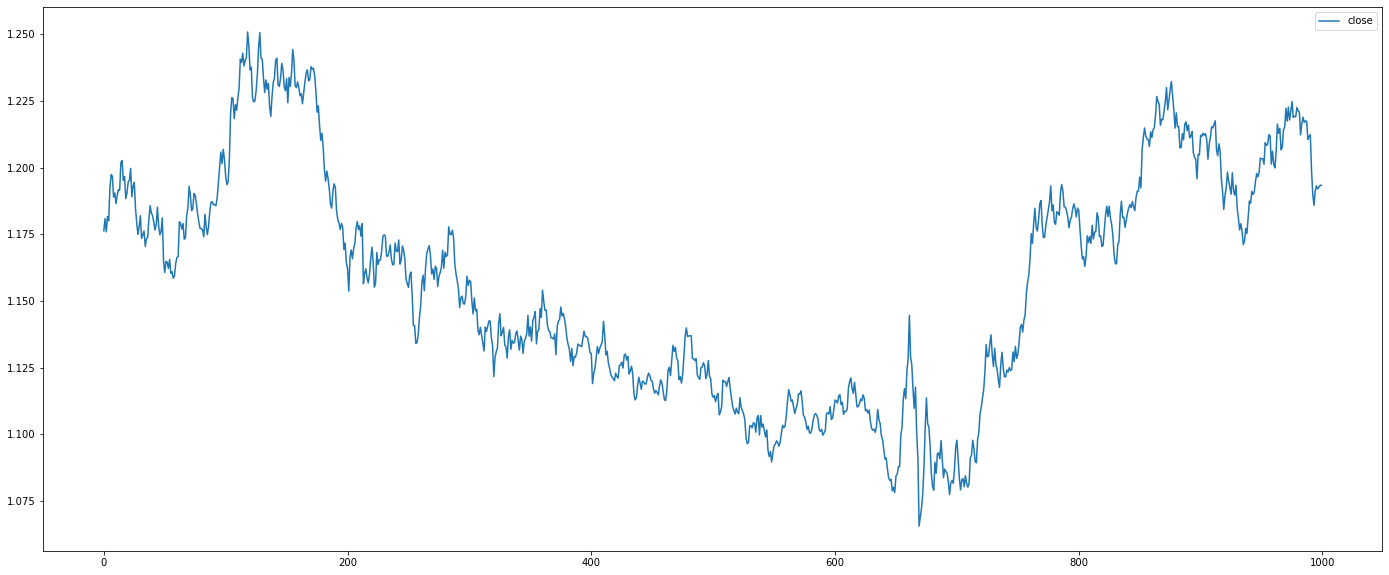

In [21]:
df = pd.read_csv('./Datasets/closing price {}_{}.csv'.format(Symbol, Timeframe), index_col=False)
print(df)
df.fillna(0, inplace=True)
df.plot(figsize=(24,10))

In [22]:
train = df[0:int(len(df)*0.80)]
#scale the data
scale = MinMaxScaler(feature_range=(-1, 1))
#Scale the data
scaled_df = scale.fit_transform(train)
print(scaled_df)

-02]
 [-3.03586863e-02]
 [ 1.10198790e-02]
 [ 2.54969749e-02]
 [ 4.72126188e-02]
 [ 1.16789110e-01]
 [ 4.36473639e-02]
 [ 1.08578220e-01]
 [ 9.05358686e-02]
 [ 9.75583405e-02]
 [ 2.11430424e-01]
 [ 1.80639585e-01]
 [ 1.79127053e-01]
 [ 1.97709594e-01]
 [ 1.67134831e-01]
 [ 6.07173725e-02]
 [ 2.04191876e-02]
 [-6.91443388e-03]
 [-4.05142610e-02]
 [-1.15492653e-01]
 [-7.53025065e-02]
 [-6.92523768e-02]
 [-1.00043215e-01]
 [-1.01339672e-01]
 [-6.86041487e-02]
 [ 1.13439931e-02]
 [-2.61452031e-02]
 [-5.18582541e-03]
 [-1.02636128e-02]
 [-8.96715644e-02]
 [-1.41637857e-01]
 [-7.64909248e-02]
 [-1.29105445e-01]
 [-1.22407087e-01]
 [-2.07649092e-01]
 [-2.25583405e-01]
 [-1.95224719e-01]
 [-2.28068280e-01]
 [-2.59615385e-01]
 [-2.91162489e-01]
 [-1.95116681e-01]
 [-2.11970614e-01]
 [-1.90795160e-01]
 [-1.69835782e-01]
 [-1.70051858e-01]
 [-2.37251513e-01]
 [-2.68906655e-01]
 [-3.95095073e-01]
 [-3.18063959e-01]
 [-2.94619706e-01]
 [-2.78846154e-01]
 [-1.78370787e-01]
 [-1.40773552e-01]
 [-2.30

In [23]:
def processData(df,lb):
    X,Y = [],[]
    for i in range(len(df)-lb-1):
        X.append(df[i:(i+lb),0])
        Y.append(df[(i+lb),0])
    return np.array(X),np.array(Y)

In [24]:
lb=14
train_size = 0.9
X,y = processData(scaled_df,lb)
X_train,X_test = X[:int(X.shape[0]*train_size)],X[int(X.shape[0]*train_size):]
y_train,y_test = y[:int(y.shape[0]*train_size)],y[int(y.shape[0]*train_size):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

706 14
79 14
706
79


In [25]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
 
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Fit model with history to check for overfitting
history = model.fit(
    X_train,y_train,
    epochs=150,
    validation_data=(X_test,y_test),
    shuffle=False
    )

model.save('my_model 150epochs.h5')

] - 1s 29ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 53/150
23/23 [==============================] - 1s 27ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 54/150
23/23 [==============================] - 1s 28ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 55/150
23/23 [==============================] - 1s 27ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 56/150
23/23 [==============================] - 1s 27ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 57/150
23/23 [==============================] - 1s 27ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 58/150
23/23 [==============================] - 1s 28ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 59/150
23/23 [==============================] - 1s 29ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 60/150
23/23 [==============================] - 1s 27ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 61/150
23/23 [==============================] - 1s 28ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 62/150
23/23 [====================

Text(0.5, 1.0, 'Trained Dataset')

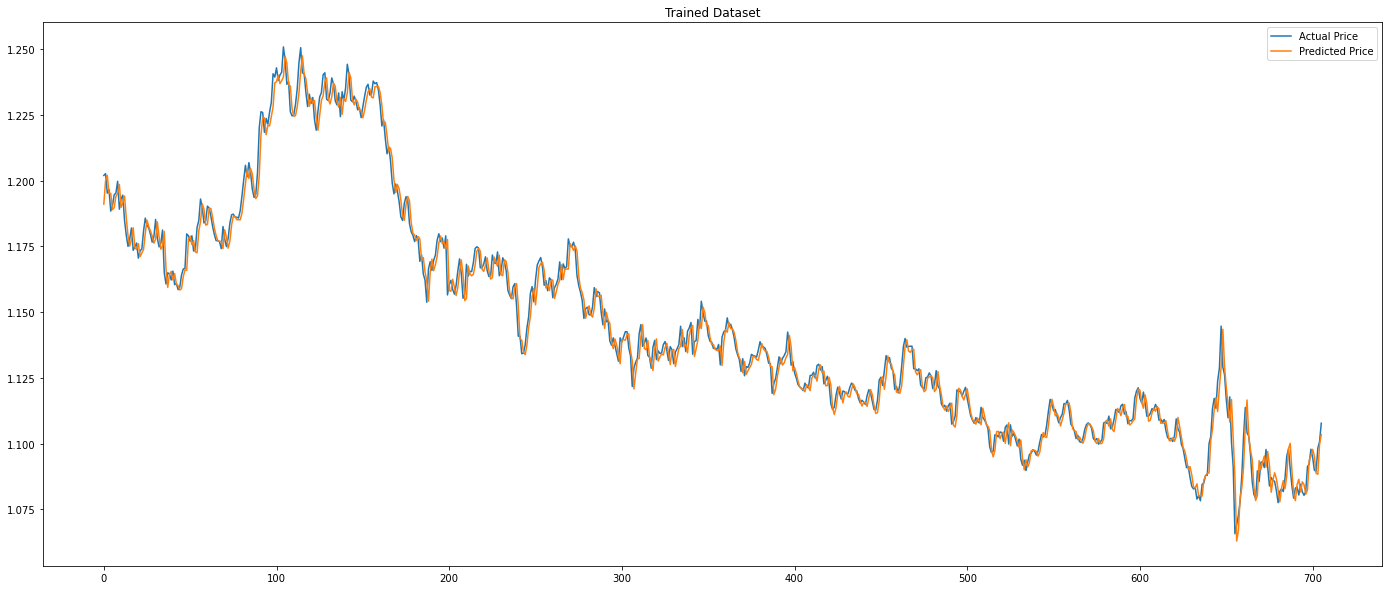

In [16]:
plt.figure(figsize=(24,10))
 
Xt = model.predict(X_train)
plt.plot(scale.inverse_transform(y_train.reshape(-1,1)), label="Actual Price")
plt.plot(scale.inverse_transform(Xt), label="Predicted Price")
plt.legend()
plt.title("Trained Dataset")